In [1]:
import os # OS e.g directory structure
import numpy as np # linear algebra
import scipy as sc  # scientific computing
import pandas as pd # data processing, file I/O
import seaborn as sns  # visualization
import matplotlib.pyplot as plt # visualization
import warnings
warnings.filterwarnings("ignore")

In [32]:

import sys

from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler,OneHotEncoder,StringIndexer,VectorIndexer
from pyspark.ml.classification import LogisticRegression
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
import numpy as np
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import RandomForestClassifier

In [3]:

! ls -la
! head -n 3 library-collection-inventory.csv

total 22983768
drwxr-xr-x  5 macbookpro  staff          160 21 Mai 12:17 .
drwxr-xr-x  6 macbookpro  staff          192  6 Mai 14:27 ..
drwxr-xr-x  3 macbookpro  staff           96  7 Mai 00:31 .ipynb_checkpoints
-rw-r--r--@ 1 macbookpro  staff        16991 21 Mai 12:17 TP_BIG_DATA.ipynb
-rw-rw-r--@ 1 macbookpro  staff  11764863851  1 Dez  2019 library-collection-inventory.csv
BibNum,Title,Author,ISBN,PublicationYear,Publisher,Subjects,ItemType,ItemCollection,FloatingItem,ItemLocation,ReportDate,ItemCount
3011076,"A tale of two friends / adapted by Ellie O'Ryan ; illustrated by Tom Caulfield, Frederick Gardner, Megan Petasky, and Allen Tam.","O'Ryan, Ellie","1481425730, 1481425749, 9781481425735, 9781481425742",2014.,"Simon Spotlight,","Musicians Fiction, Bullfighters Fiction, Best friends Fiction, Friendship Fiction, Adventure and adventurers Fiction",jcbk,ncrdr,Floating,qna,2017-09-01T00:00:00.000,1
2248846,"Naruto. Vol. 1, Uzumaki Naruto / story and art by Masashi Kishimoto ; [Engli

In [4]:
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, TimestampType, DoubleType,ArrayType

fire_schema = StructType([StructField("BibNum", IntegerType(),True),
                             StructField("Title", StringType(),True),
                             StructField("Author", StringType(),True),
                             StructField("ISBN", IntegerType(),True),
                             StructField("PublicationYear", IntegerType(),True),
                             StructField("Publisher", StringType(),True),
                             StructField("Subjects", StringType(), True),
                             StructField("ItemType", StringType(),True),
                             StructField("ItemCollection", StringType(),True),
                             StructField("FloatingItem", StringType(),True),
                             StructField("ItemLocation", StringType(),True),
                             StructField("ReportDate", TimestampType(),True),
                             StructField("ItemCount", IntegerType(),True)
                            ])


In [5]:


df = spark.read.csv('library-collection-inventory.csv',header=True, schema=fire_schema, sep=",")



### Exploratory data analysis

In [6]:
df.printSchema()
cols = df.columns
df.count()

root
 |-- BibNum: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- ISBN: integer (nullable = true)
 |-- PublicationYear: integer (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- Subjects: string (nullable = true)
 |-- ItemType: string (nullable = true)
 |-- ItemCollection: string (nullable = true)
 |-- FloatingItem: string (nullable = true)
 |-- ItemLocation: string (nullable = true)
 |-- ReportDate: timestamp (nullable = true)
 |-- ItemCount: integer (nullable = true)



35531308

# Data cleaning




In [7]:
df_1 = df.dropna(subset=["Author","Publisher"])

In [8]:
df_1 = df_1.na.fill({'PublicationYear':0,'Subjects':'unknown',
                     'ItemType':'no_type','ItemCollection':'no_collection'})

In [ ]:
#df_1.select('PublicationYear','Subjects','ItemType').where(col('PublicationYear')>0).show()

In [9]:
max_row =10000

df_clean = df_1.limit(max_row)

df_clean.count()

10000

### Data Trasformation and extraction

In [10]:

def transformToIndex(inputArr, data):
    indexer=None 
    for col_in, col_out in inputArr.items():
        
        indexer = StringIndexer(inputCol=col_in, outputCol=col_out)
        data = indexer.fit(data).transform(data)
        
        # converçao para int 
        #data = data.withColumn(col_out, data[col_out].cast(IntegerType()))
    return data
col_to_trasform = {
                   'Author':'AuthorIndex', 
                   'Publisher':'PublisherIndex',
                   'ItemCollection': 'ItemCollectionIndex',
                    'Subjects':'SubjectIndex',
                    'ItemType':'ItemTypeIndex'
                   }
#'Author':'AuthorIndex', 'Publisher':'PublisherIndex','ItemCollection': 'ItemCollectionIndex'

In [11]:
df_clean = transformToIndex(col_to_trasform,df_clean)

transformToIndex(col_to_trasform,df_clean)

In [12]:
df_clean.printSchema()


root
 |-- BibNum: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- ISBN: integer (nullable = true)
 |-- PublicationYear: integer (nullable = false)
 |-- Publisher: string (nullable = true)
 |-- Subjects: string (nullable = false)
 |-- ItemType: string (nullable = false)
 |-- ItemCollection: string (nullable = false)
 |-- FloatingItem: string (nullable = true)
 |-- ItemLocation: string (nullable = true)
 |-- ReportDate: timestamp (nullable = true)
 |-- ItemCount: integer (nullable = true)
 |-- AuthorIndex: double (nullable = false)
 |-- PublisherIndex: double (nullable = false)
 |-- ItemCollectionIndex: double (nullable = false)
 |-- SubjectIndex: double (nullable = false)
 |-- ItemTypeIndex: double (nullable = false)



### Tratamento da Variavel Preditora 

In [13]:
data = df_clean.select(
"AuthorIndex","ItemCollectionIndex"
    ,"PublisherIndex",'SubjectIndex','ItemTypeIndex')
data.show()

+-----------+-------------------+--------------+------------+-------------+
|AuthorIndex|ItemCollectionIndex|PublisherIndex|SubjectIndex|ItemTypeIndex|
+-----------+-------------------+--------------+------------+-------------+
|     5797.0|               13.0|          27.0|      5569.0|          1.0|
|      107.0|               12.0|         493.0|       261.0|          0.0|
|      912.0|               12.0|         193.0|      2691.0|          0.0|
|     2020.0|                7.0|        1565.0|      3907.0|          0.0|
|      243.0|               29.0|         867.0|      5033.0|          0.0|
|     5834.0|               75.0|         343.0|      7818.0|          0.0|
|     3053.0|                1.0|           9.0|      2122.0|          0.0|
|      861.0|                7.0|           7.0|      3286.0|          0.0|
|     2750.0|               17.0|        3422.0|      6177.0|          1.0|
|     5136.0|                3.0|         556.0|       605.0|          0.0|
|     7413.0

In [14]:
col_to_drop = ['ItemCount','FloatingItem','ReportDate']

In [15]:
cols_feactures = [c for c in cols if c not in col_to_drop]
col_interesting = ['PublisherIndex','AuthorIndex','ItemCollectionIndex','SubjectIndex','ItemTypeIndex']

In [16]:
# Correlation requires vectors so prior we convert to vector column
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=col_interesting, outputCol=vector_col)
df_vector = assembler.transform(df_clean).select(vector_col)

# get correlation matrix

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
# corrmatrix
corrmatrix

[[1.0,
  0.1672540728248159,
  0.027107451895807187,
  -0.017328209317955437,
  0.17044476272755527],
 [0.1672540728248159,
  1.0,
  -0.05300057754256645,
  0.0774286616240817,
  -0.032258727678151126],
 [0.027107451895807187,
  -0.05300057754256645,
  1.0,
  0.007499562129496555,
  0.3569697237184988],
 [-0.017328209317955437,
  0.0774286616240817,
  0.007499562129496555,
  1.0,
  -0.06838643844895669],
 [0.17044476272755527,
  -0.032258727678151126,
  0.3569697237184988,
  -0.06838643844895669,
  1.0]]

In [25]:

def ScatterPlot(df, width, height):
    plt.figure(figsize=(width, height))
    plt.pcolor(df)
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
    plt.show()


In [26]:
df_plot = pd.DataFrame(data=corrmatrix)

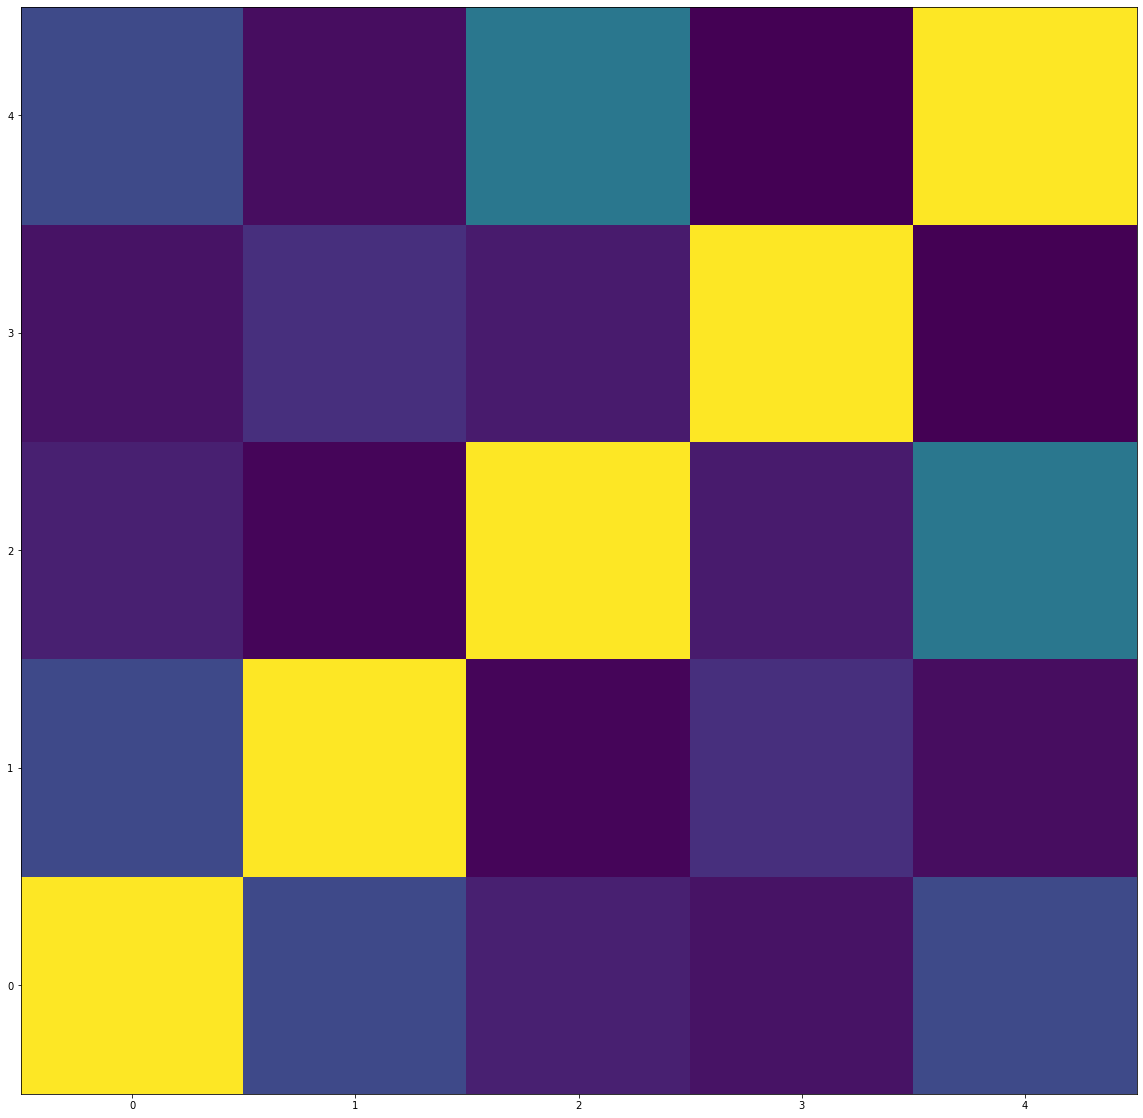

In [27]:
ScatterPlot(df_plot, 20, 20)

In [21]:
divideData = data.randomSplit([0.7,0.3])
trainingData = divideData[0]
testingData = divideData[1]
train_rows = trainingData.count()
test_row = testingData.count()
print("training data rows:", train_rows, "; testing data row:", test_row)

training data rows: 7109 ; testing data row: 2891


In [45]:
assembler = VectorAssembler(inputCols=["AuthorIndex","PublisherIndex","ItemCollectionIndex"], outputCol="features")

traiDataFinal = assembler.transform(trainingData).select(col("features"),col('ItemTypeIndex').alias('label'))
traiDataFinal.show(truncate=False,n=2)

+-------------+-----+
|features     |label|
+-------------+-----+
|[0.0,4.0,3.0]|0.0  |
|[0.0,4.0,3.0]|0.0  |
+-------------+-----+
only showing top 2 rows



### Classifier our model 

In [46]:
#define our classifier
classifier = LogisticRegression(labelCol="label", featuresCol="features",maxIter=10,regParam=0.3)
#train our classifier
model= classifier.fit(traiDataFinal)
print("classifier Model is trained")

classifier Model is trained


In [51]:
trainingSummary = model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

AttributeError: 'LogisticRegressionTrainingSummary' object has no attribute 'roc'

In [47]:
testingDataFinal = assembler.transform(testingData).select(col("features"),col("ItemTypeIndex").alias('trueLabel'))
testingDataFinal.show()

+-----------------+---------+
|         features|trueLabel|
+-----------------+---------+
|    [0.0,4.0,3.0]|      0.0|
|    [0.0,4.0,6.0]|      1.0|
|   [0.0,45.0,6.0]|      1.0|
|  [0.0,64.0,35.0]|      2.0|
|  [0.0,64.0,35.0]|      2.0|
|[0.0,2514.0,36.0]|      1.0|
| [0.0,163.0,39.0]|      0.0|
|  [0.0,64.0,53.0]|      4.0|
| [0.0,524.0,53.0]|      4.0|
|    [1.0,8.0,6.0]|      1.0|
|    [1.0,8.0,6.0]|      1.0|
|   [1.0,8.0,44.0]|      1.0|
|   [1.0,8.0,44.0]|      1.0|
|  [2.0,16.0,13.0]|      1.0|
|   [2.0,8.0,17.0]|      1.0|
|   [2.0,8.0,17.0]|      1.0|
|   [2.0,8.0,17.0]|      1.0|
|  [2.0,16.0,17.0]|      1.0|
|  [2.0,16.0,17.0]|      1.0|
|   [2.0,8.0,44.0]|      1.0|
+-----------------+---------+
only showing top 20 rows



### Predict the testing data using our Trained Model

In [48]:
prediction = model.transform(testingDataFinal)
predictionFinal = prediction.select("features","prediction","probability","trueLabel")
predictionFinal.show(truncate=False,n=3)

+--------------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|features      |prediction|probability                                                                                                                                                                                                   


## Calculate our model Performance

In [49]:
correctPrediction = predictionFinal.filter(predictionFinal['prediction']== predictionFinal['trueLabel']).count()

totalData = predictionFinal.count()
print("Correct Prediction:", correctPrediction, ", Total Data:", totalData,
     ", accuracy:", correctPrediction/totalData)

Correct Prediction: 1612 , Total Data: 2891 , accuracy: 0.5575925285368385


In [44]:
predictionFinal.show()

+--------------------+----------+--------------------+---------+
|            features|prediction|         probability|trueLabel|
+--------------------+----------+--------------------+---------+
| [0.0,4.0,3.0,279.0]|       0.0|[0.47565155370511...|      0.0|
|[0.0,4.0,6.0,5300.0]|       0.0|[0.51134233693509...|      1.0|
|[0.0,45.0,6.0,124.0]|       0.0|[0.46835765167595...|      1.0|
|[0.0,64.0,35.0,24...|       0.0|[0.40868849092576...|      2.0|
|[0.0,64.0,35.0,23...|       0.0|[0.42568880643653...|      2.0|
|[0.0,2514.0,36.0,...|       0.0|[0.47743186257874...|      1.0|
|[0.0,163.0,39.0,9...|       0.0|[0.40682046478219...|      0.0|
|[0.0,64.0,53.0,81...|       0.0|[0.43531780934393...|      4.0|
|[0.0,524.0,53.0,1...|       1.0|[0.38646121431850...|      4.0|
| [1.0,8.0,6.0,336.0]|       0.0|[0.46984397512063...|      1.0|
|[1.0,8.0,6.0,7639.0]|       0.0|[0.53063606768898...|      1.0|
|[1.0,8.0,44.0,526...|       0.0|[0.43068718100075...|      1.0|
|[1.0,8.0,44.0,527...|   